In [16]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import utils, generate_wind

In [2]:
config = utils.load_config("config.yaml")

dir = os.path.join(config['data']['raw_dir'], 'wind')
val_dir = config['data']['re_ninja_dir']
synth_dir = os.path.join(config['data']['synth_dir'], 'wind')
turbine_dir = config['data']['turbine_dir']
turbine_power = config['data']['turbine_power']
turbine_path = os.path.join(turbine_dir, turbine_power)
specs_path = config['data']['turbine_specs']
specs_path = os.path.join(turbine_dir, specs_path)
cp_path = config["data"]["turbine_cp"]
cp_path = os.path.join(turbine_dir, cp_path)
results_dir = 'results'

os.makedirs(results_dir, exist_ok=True)

features = config['features']

params = config['wind_params']

mapping = {'electricity_1': 'Enercon E-70 E4 2.300',
           'electricity_2': 'Enercon E-82 E2 2.000',
           'electricity_3': 'Enercon E-115 2.500',
           'electricity_4': 'Vestas V90',
           'electricity_5': 'Vestas V112-3.45',
           'electricity_6': 'Vestas V80-1.8'
           }

In [3]:
# get validationd data
files = os.listdir(val_dir)
station_files = [f for f in files if 'metadata' not in f and f.endswith('.csv')]
metadata_files = [f for f in files if 'metadata' in f and f.endswith('.csv')]
station_files.sort()
metadata_files.sort()
print(len(station_files), 'station files in validation data found')

files = os.listdir(synth_dir)
station_files_synthetic = [f for f in files if 'metadata' not in f and f.endswith('.csv')]
station_files_synthetic.sort()
print(len(station_files_synthetic), 'station files in synthetic data found')

raw_power_curves, cp_curves, specs = generate_wind.get_turbines(turbine_path=turbine_path,
                                                        cp_path=cp_path,
                                                        specs_path=specs_path,
                                                        params=params)
power_curves = pd.DataFrame()
for turbine in raw_power_curves.columns:
    power_curve = generate_wind.interpolate(power_curve=raw_power_curves[turbine],
                                            cut_out=specs[turbine]['cut_out'])
    power_curves[turbine] = power_curve
power_curves /= 1000 # convert to kW

39 station files in validation data found
39 station files in synthetic data found


In [4]:
val_dfs = []
dfs = []

for st, md in zip(station_files, metadata_files):
    station = pd.read_csv(os.path.join(val_dir, st))
    station['datetime'] = pd.to_datetime(station['datetime'])
    station.set_index('datetime', inplace=True)
    #metadata = pd.read_csv(os.path.join(path, md))
    val_dfs.append(station)

for st in station_files_synthetic:
    station = pd.read_csv(os.path.join(synth_dir, st), sep=';')
    station['timestamp'] = pd.to_datetime(station['timestamp'])
    station.set_index('timestamp', inplace=True)
    station = station['2024-01-01':'2025-01-01']
    for key, value in mapping.items():
        station[value] /= 1000 # convert to kW
    #metadata = pd.read_csv(os.path.join(path, md))
    dfs.append(station)

In [8]:
def plot_power_curves(data_a, data_b, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()  # einfacher Zugriff

    for i, turbine in enumerate(map(str, range(1, 7))):
        turbine_name = mapping[f'electricity_{turbine}']

        ax = axes[i]
        sns.scatterplot(data=data_a, x='wind_speed_hub', y=turbine_name, label=f'synthetic {turbine_name}', ax=ax)
        sns.scatterplot(data=data_b, x=f'wind_speed_{turbine}', y='electricity_1', label=f'renewables.ninja {turbine_name}', ax=ax)
        sns.lineplot(data=power_curves[turbine_name], label=f'power curve {turbine_name}', color='red', linewidth=2, ax=ax)

        ax.set_title(f'Turbine {turbine_name}')
        ax.set_xlabel('Wind Speed [m/s]')
        ax.set_ylabel('Electricity [kW]')
        ax.legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
        plt.close(fig)

def plot_power_distribution(data_a, data_b, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, turbine in enumerate(map(str, range(1, 7))):
        turbine_name = mapping[f'electricity_{turbine}']

        df_ex_zero = data_a[data_a[turbine_name] > 0]
        val_df_ex_zero = data_b[data_b[f'electricity_{turbine}'] > 0]

        ax = axes[i]
        sns.histplot(data=df_ex_zero, x=turbine_name, label=f'synthetic {turbine_name}', bins=50, kde=True, ax=ax)
        sns.histplot(data=val_df_ex_zero, x=f'electricity_{turbine}', label=f'renewables.ninja {turbine_name}', bins=50, kde=True, ax=ax)

        ax.set_title(f'Power distribution {turbine_name}')
        ax.set_xlabel('Electricity [kW]')
        ax.set_ylabel('Frequency')
        ax.legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
        plt.close(fig)

def plot_wind_speed_distrbution(data_a, data_b, save_path=None):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, turbine in enumerate(map(str, range(1, 7))):
        turbine_name = mapping[f'electricity_{turbine}']
        height = specs[turbine_name]['height']

        ax = axes[i]
        sns.histplot(data=data_a, x='wind_speed_hub', label=f'synthetic {turbine_name}', bins=50, kde=True, ax=ax)
        sns.histplot(data=data_b, x=f'wind_speed_{turbine}', label=f'renewables.ninja {turbine_name}', bins=50, kde=True, ax=ax)

        ax.set_title(f'Wind speed @ {height} m ({turbine_name})')
        ax.set_xlabel('Wind Speed [m/s]')
        ax.set_ylabel('Frequency')
        ax.legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600)
        plt.close(fig)

def get_stats(data_a, data_b, print_stats=True):
    stats = {}
    for i, turbine in enumerate(map(str, range(1, 7))):
        synth_sum = 0
        re_ninja_sum = 0
        turbine_name = mapping[f'electricity_{turbine}']
        synth_turbine_power = data_a[turbine_name].sum()/10000
        stats[f'synthetic {turbine_name}'] = synth_turbine_power
        re_ninja_turbine = f'electricity_{turbine}'
        re_ninja_turbine_power = data_b[re_ninja_turbine].sum()/10000
        stats[f're.ninja {turbine_name}'] = re_ninja_turbine_power
        synth_sum += synth_turbine_power
        re_ninja_sum += re_ninja_turbine_power
        if print_stats:
            print(f'Turbine {turbine_name}:')
            print(f'Synthetic energy: {synth_turbine_power:.2f} MWh')
            print(f'Renewables.ninja energy: {re_ninja_turbine_power:.2f} MWh')
            print('')
    if print_stats:
        print(f'Total synthetic energy: {synth_sum:.2f} MWh')
        print(f'Total renewables.ninja energy: {re_ninja_sum:.2f} MWh')
    return stats


Processing station 00164 (1) of 39
Processing station 00183 (2) of 39
Processing station 00342 (3) of 39


KeyboardInterrupt: 

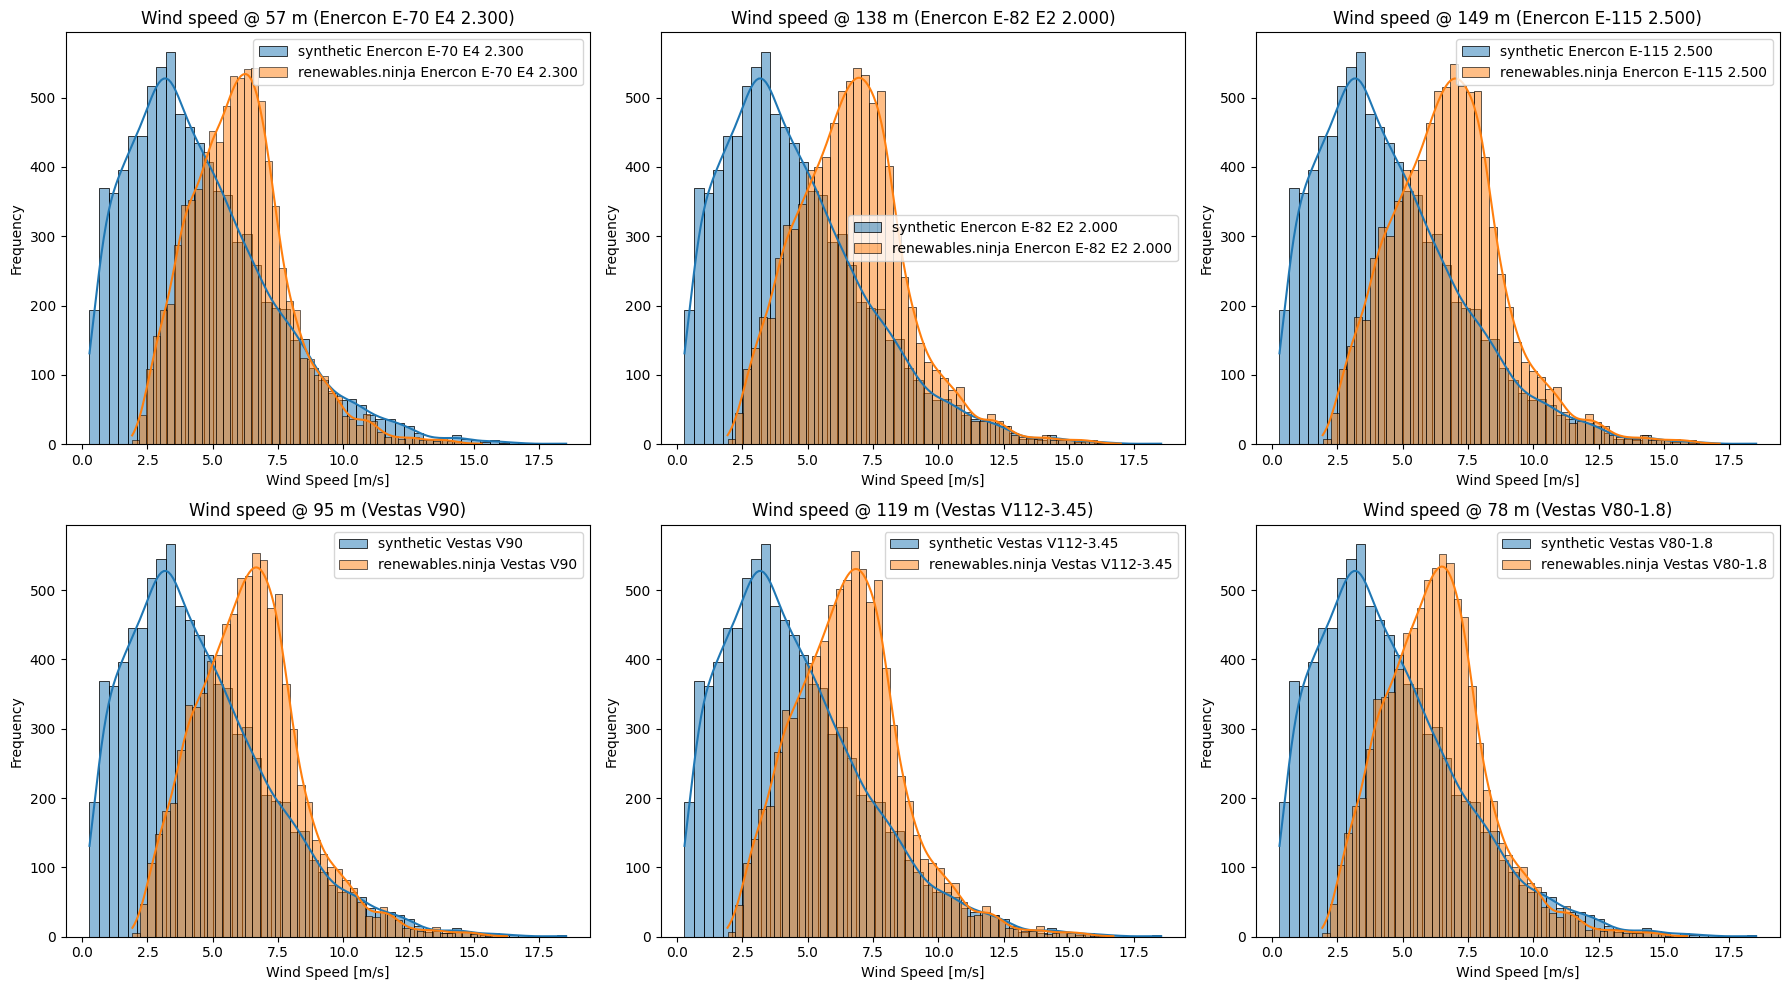

In [22]:
power_curves_base_dir = os.path.join(results_dir, 'power_curves')
power_distr_base_dir = os.path.join(results_dir, 'power_distribution')
wind_speed_distr_base_dir = os.path.join(results_dir, 'wind_speed_distribution')
os.makedirs(power_curves_base_dir, exist_ok=True)
os.makedirs(power_distr_base_dir, exist_ok=True)
os.makedirs(wind_speed_distr_base_dir, exist_ok=True)

# get results for all station locations
station_names = []
stats = defaultdict(list)
for nr, station in enumerate(station_files):
    station_name = station.split('.')[0]
    station_names.append(station_name)
    print(f'Processing station {station_name} ({nr+1}) of {len(station_files)}')
    power_curves_dir = os.path.join(power_curves_base_dir, f'power_curves_{station_name}.png')
    power_distr_dir = os.path.join(power_distr_base_dir, f'power_distribution_{station_name}.png')
    wind_speed_distr_dir = os.path.join(wind_speed_distr_base_dir, f'wind_speed_distribution_{station_name}.png')
    plot_power_curves(data_a=dfs[nr], data_b=val_dfs[nr], save_path=power_curves_dir)
    plot_power_distribution(data_a=dfs[nr], data_b=val_dfs[nr], save_path=power_distr_dir)
    plot_wind_speed_distrbution(data_a=dfs[nr], data_b=val_dfs[nr], save_path=wind_speed_distr_dir)
    new_stats = get_stats(data_a=dfs[nr], data_b=val_dfs[nr], print_stats=False)
    for key, value in new_stats.items():
        stats[key].append(value)
results = pd.DataFrame(data=stats, index=station_names)

In [45]:
# show results for specific station locations
nr = 3

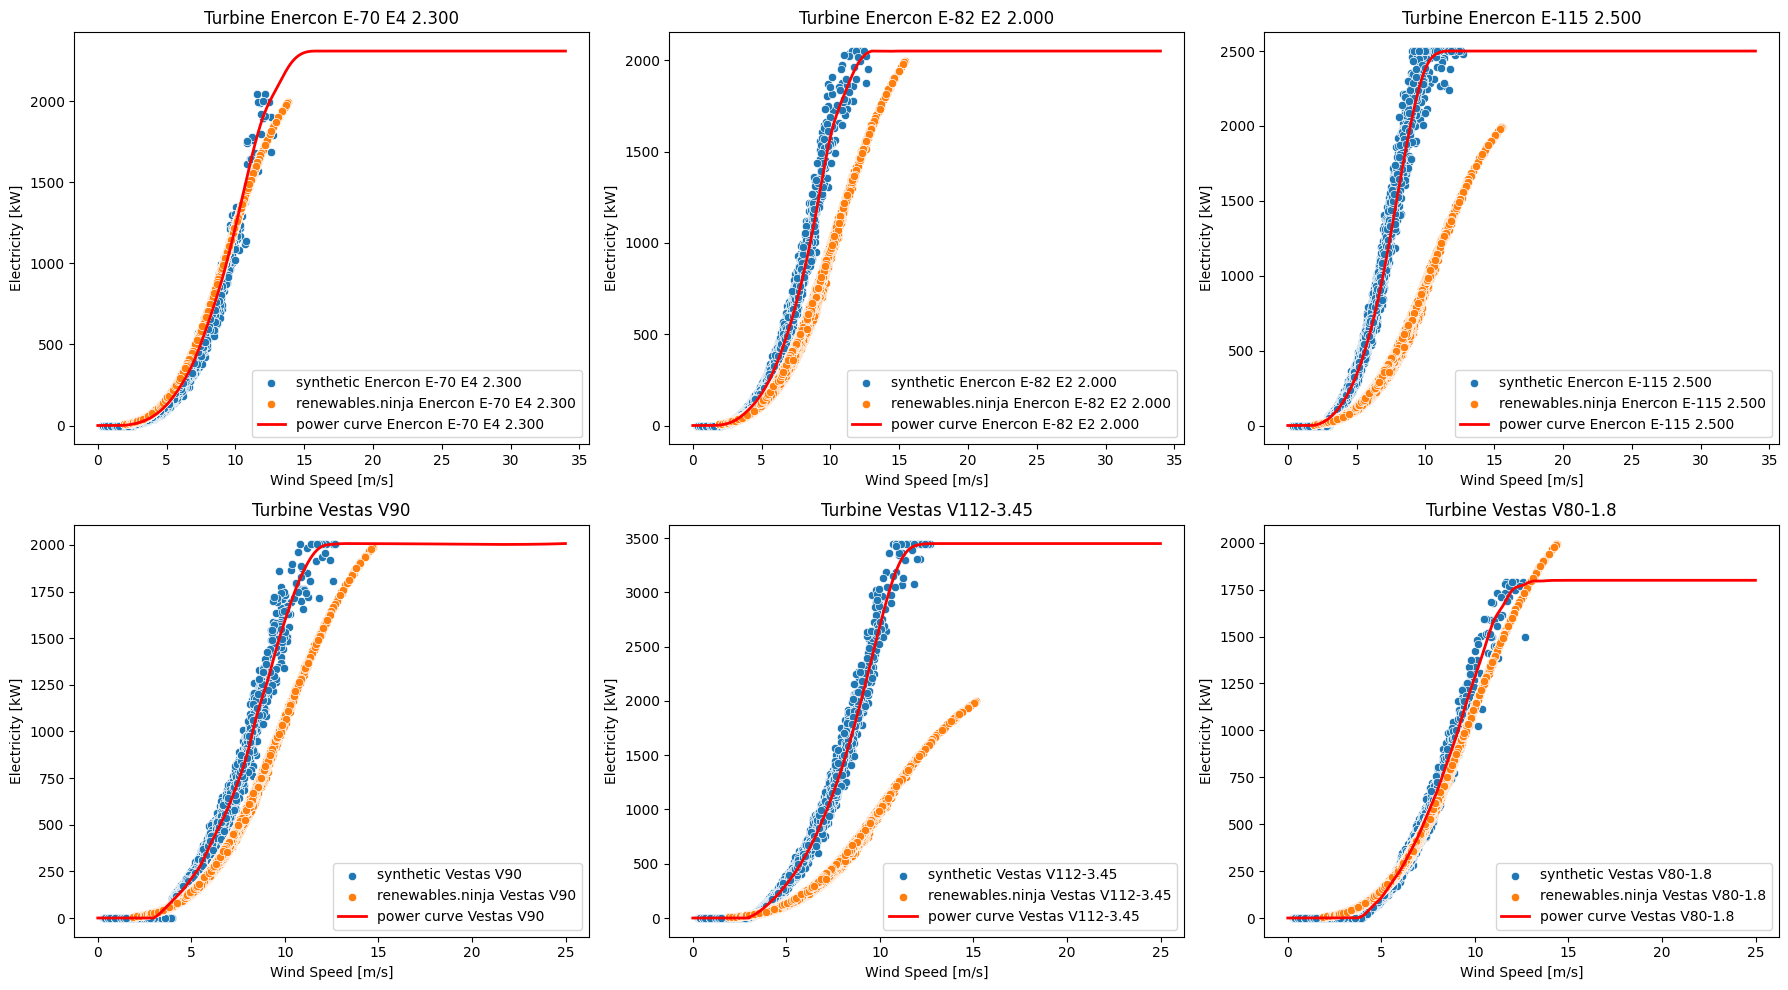

In [39]:
plot_power_curves(dfs[nr], val_dfs[nr])

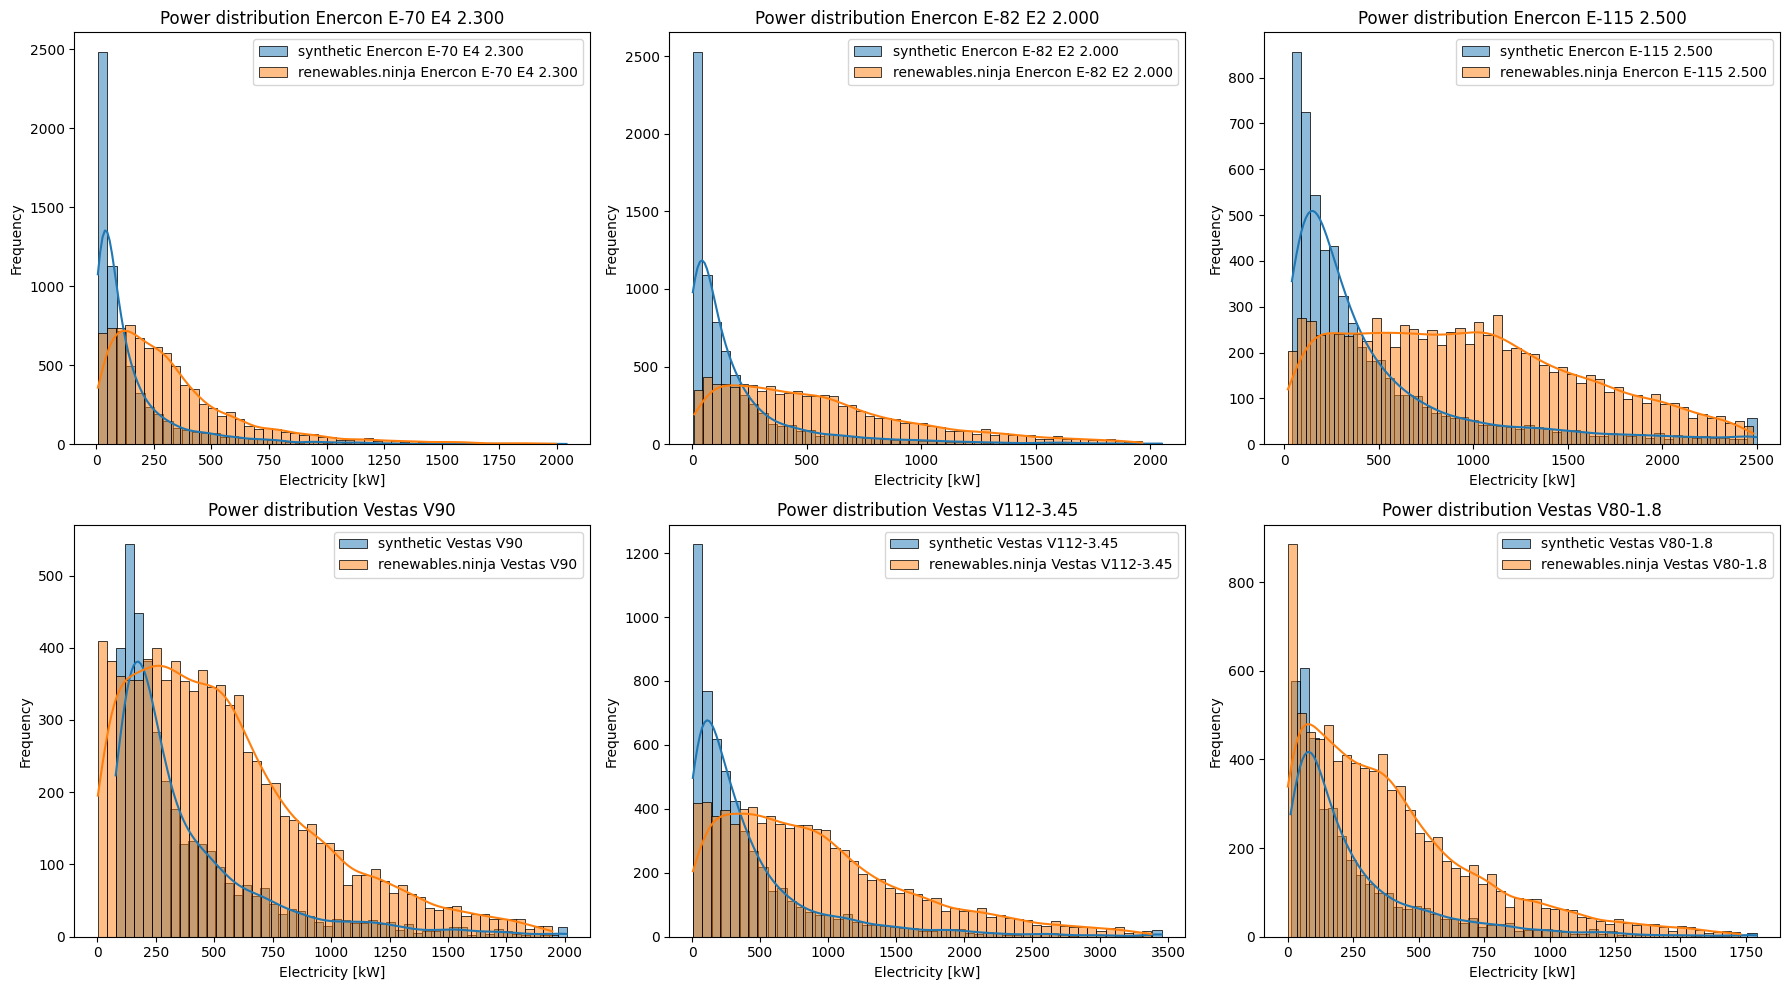

In [41]:
plot_power_distribution(dfs[nr], val_dfs[nr])

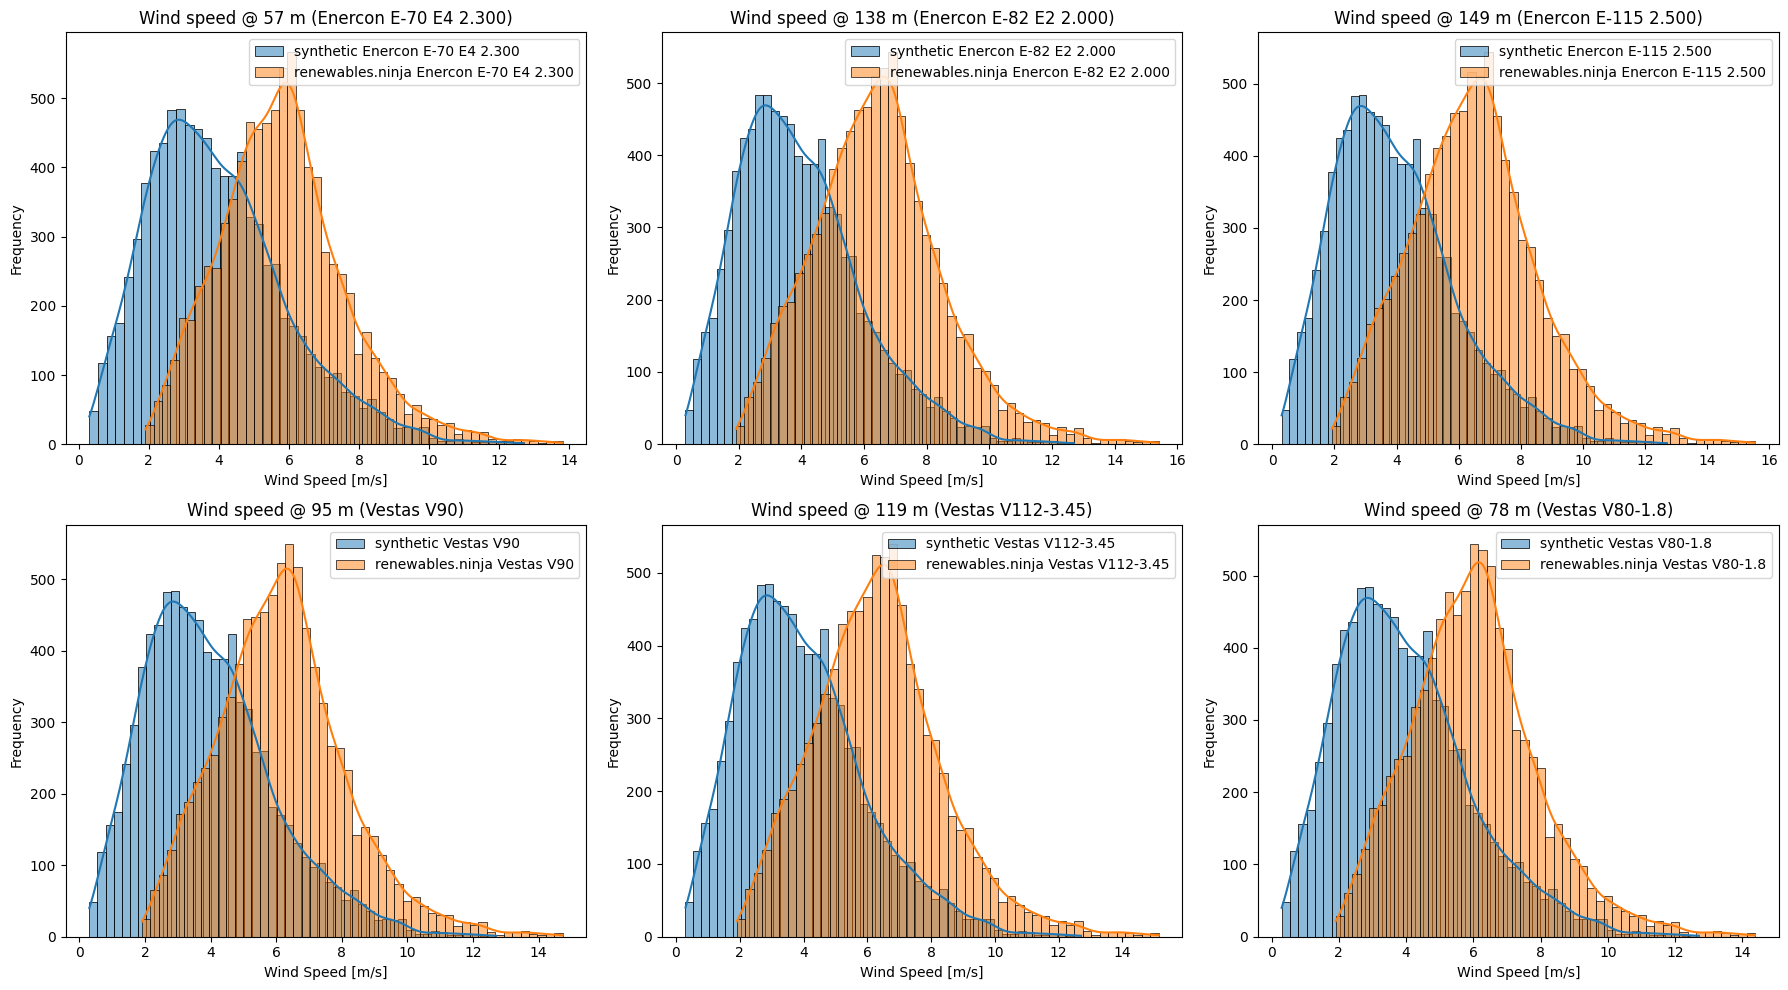

In [42]:
plot_wind_speed_distrbution(dfs[nr], val_dfs[nr])

In [30]:
get_stats(dfs[nr], val_dfs[nr])

Turbine Enercon E-70 E4 2.300:
Synthetic energy: 178.58 MWh
Renewables.ninja energy: 327.72 MWh

Turbine Enercon E-82 E2 2.000:
Synthetic energy: 305.48 MWh
Renewables.ninja energy: 541.30 MWh

Turbine Enercon E-115 2.500:
Synthetic energy: 516.40 MWh
Renewables.ninja energy: 913.79 MWh

Turbine Vestas V90:
Synthetic energy: 282.46 MWh
Renewables.ninja energy: 516.61 MWh

Turbine Vestas V112-3.45:
Synthetic energy: 496.09 MWh
Renewables.ninja energy: 889.52 MWh

Turbine Vestas V80-1.8:
Synthetic energy: 196.90 MWh
Renewables.ninja energy: 381.79 MWh

Total synthetic energy: 196.90 MWh
Total renewables.ninja energy: 381.79 MWh


{'synthetic Enercon E-70 E4 2.300': 178.58113832726224,
 're.ninja Enercon E-70 E4 2.300': 327.7188938,
 'synthetic Enercon E-82 E2 2.000': 305.4798702647693,
 're.ninja Enercon E-82 E2 2.000': 541.2994819,
 'synthetic Enercon E-115 2.500': 516.3976368950466,
 're.ninja Enercon E-115 2.500': 913.7887507999999,
 'synthetic Vestas V90': 282.4595129692713,
 're.ninja Vestas V90': 516.6053392,
 'synthetic Vestas V112-3.45': 496.0889512917383,
 're.ninja Vestas V112-3.45': 889.5152178999999,
 'synthetic Vestas V80-1.8': 196.89936877719197,
 're.ninja Vestas V80-1.8': 381.7881004000001}